# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [4]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [1]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [2]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

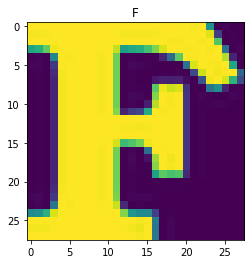

In [3]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

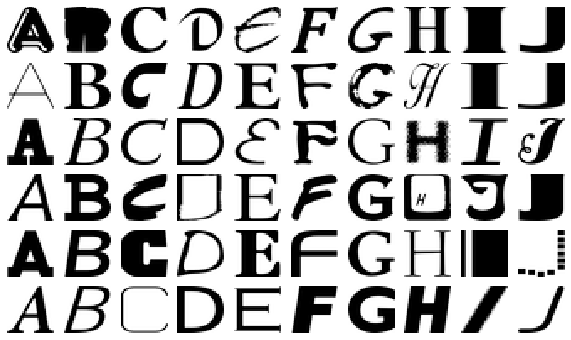

In [4]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [5]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [6]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Optimizer를 따로 선언해서 사용
3. Dropout을 0.2 정도로 활용해볼 것
4. 초기값은 default로
5. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
6. Early stopping도 활용해볼 것

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import *

keras.backend.clear_session()

il = Input(shape=x_train.shape[1:])
fl = Flatten()(il)
h1 = Dense(512, activation='relu')(fl)
b1 = BatchNormalization()(h1)
h2 = Dense(512, activation='relu')(b1)
b2 = BatchNormalization()(h2)
h3 = Dense(256, activation='relu')(b2)
b3 = BatchNormalization()(h3)
dl = Dropout(.2)(b3)
ol = Dense(10, activation='softmax')(dl)

model = keras.models.Model(il, ol)

model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

In [9]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True)

In [13]:
mcp = keras.callbacks.ModelCheckpoint(filepath='./content/model.ckpt',
                                      monitor='val_loss',
                                      verbose=1,
                                      save_best_only=True,
                                      save_weights_only=True)

In [14]:
model.fit(x_train, y_train, epochs=100, verbose=1,
          callbacks=[es, mcp],
          validation_split=.2)

Epoch 1/100
358/375 [===========================>..] - ETA: 0s - loss: 0.2916 - accuracy: 0.9124
Epoch 00001: val_loss improved from inf to 0.41762, saving model to ./content\model.ckpt
375/375 [==============================] - 1s 3ms/step - loss: 0.2938 - accuracy: 0.9111 - val_loss: 0.4176 - val_accuracy: 0.8882
Epoch 2/100
360/375 [===========================>..] - ETA: 0s - loss: 0.2639 - accuracy: 0.9176
Epoch 00002: val_loss did not improve from 0.41762
375/375 [==============================] - 1s 2ms/step - loss: 0.2647 - accuracy: 0.9174 - val_loss: 0.4277 - val_accuracy: 0.8922
Epoch 3/100
361/375 [===========================>..] - ETA: 0s - loss: 0.2298 - accuracy: 0.9270
Epoch 00003: val_loss improved from 0.41762 to 0.40391, saving model to ./content\model.ckpt
375/375 [==============================] - 1s 2ms/step - loss: 0.2342 - accuracy: 0.9260 - val_loss: 0.4039 - val_accuracy: 0.8905
Epoch 4/100
359/375 [===========================>..] - ETA: 0s - loss: 0.2121 - acc

In [20]:
model.evaluate(x_test, y_test)

118/118 [==============================] - 0s 3ms/step - loss: 0.3219 - accuracy: 0.9071


[0.32185477018356323, 0.9070761203765869]

In [16]:
model.evaluate(x_test, y_test)

118/118 [==============================] - 0s 2ms/step - loss: 0.3286 - accuracy: 0.9060


[0.32856306433677673, 0.9060080051422119]